### Conclusiones Finales

- **Análisis Predictivo**: El modelo de red neuronal puede automatizar el proceso de calificación a partir de texto no estructurado, facilitando el monitoreo del sentimiento de los clientes a través de diversas plataformas.

- **Análisis de Sentimiento y Subjetividad**: Permite identificar el nivel general de satisfacción de los clientes y distinguir entre comentarios objetivos y opiniones subjetivas.

- **Modelado de Temas y Análisis Basado en Aspectos**: Brinda información detallada sobre áreas específicas de interés o preocupación, ayudando a la aerolínea a enfocarse en aspectos críticos a mejorar.

- **Resúmenes de Reseñas**: Ofrece una representación concisa de los comentarios de los clientes, útil para que los responsables de la toma de decisiones obtengan una visión rápida sin tener que profundizar en cada reseña individual.

### Propuesta de Valor para Flybondi

- **Mejora en la Satisfacción del Cliente**: Al comprender los sentimientos de los clientes y los aspectos que consideran importantes, Flybondi puede tomar decisiones basadas en datos para mejorar la experiencia del cliente.

- **Gestión de la Reputación**: El monitoreo del sentimiento en distintas plataformas ayuda a gestionar de manera proactiva la imagen pública de la aerolínea.

- **Planificación Estratégica**: Los conocimientos obtenidos del modelado de temas y el análisis basado en aspectos pueden orientar las estrategias de marketing y las mejoras en los servicios.

- **Asignación de Recursos**: Enfocarse en las áreas que impactan significativamente en la satisfacción del cliente permite optimizar la utilización de los recursos.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from textblob import TextBlob
import spacy
from colorama import Fore, Style

# Load the dataset
df = pd.read_csv('../../data/en_cleaned_with_lemmatized_reviews.csv')

df.head()


,name,rating,relevance_score,source_language,review
0,22fortinero,1,0.0,es,terrible terrible bad lose hotel day way back ...
1,23russellv,2,0.0,en,one bad fly fly hundred airline possibly bad b...
2,4family,1,0.0,en,terrible service flight first delay 25 minute ...
3,5travellers602013,1,0.0,en,rubbish low cost airline buy 6 ticket via book...
4,885david_r885,1,0.0,en,refund cancel flight refund cancel flight basi...


## 1 Predictive Analysis: a network to predict sentiment

aca hay una red neuronal que usa la funcion de activación logistica y es capaz de predecir que rating le da el reviewer basado en el texto. Usa Adam como optimizador ya que es el mejorcito del mercado.

### resultados en 5 epocas
- adam relu [mae= 0.17,mse=  0.045, r2<0] 
- adam linear [mae=0.17, mse=0.046, r2<0]
- adam sigmoid: [mae=0.11 , mse=0.026, r2=0.74] 
- Usando el relevance score [mae= 0.099, mse=0.026, r2= 0.74]

In [2]:
run_block = False

if run_block:
    # Import necessary libraries
    import pandas as pd
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
    from sklearn.metrics import r2_score



    # Normalizar la columna 'rating'
    df['rating_normalized'] = df['rating'] / df['rating'].max()

    # Prepare the text data
    X = df['review'].values
    y = df['rating_normalized'].values


    # Split the dataset and also keep the indices for later use
    X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, df.index, test_size=0.2, random_state=42)

    # Tokenize the text
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Pad the sequences
    maxlen = 100
    X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
    X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

    # Build the model
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])

    # Train the model
    model.fit(X_train_pad, y_train, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test))

    # Evaluate the model
    y_pred = model.predict(X_test_pad)
    r2 = r2_score(y_test, y_pred)
    loss, mae, mse = model.evaluate(X_test_pad, y_test)

    model.save('../../models/flybondi_review_predictor.h5')
    print(f"Mean Absolute Error: {mae}")
    print(f"R² Score: {r2}")
    print(f"Mean Squared Error: {mse}")

    # Use sample weights based on 'relevance_score'
    sample_weights = df.loc[train_idx, 'relevance_score'].values
    sample_weights = np.exp(sample_weights)
    model.fit(X_train_pad, y_train, sample_weight=sample_weights, batch_size=32, epochs=5, validation_data=(X_test_pad, y_test))

    # Evaluate the model again
    loss, mae, mse = model.evaluate(X_test_pad, y_test)
    y_pred = model.predict(X_test_pad)
    r2 = r2_score(y_test, y_pred)

    model.save('../../models/flybondi_review_predictor_weighted.h5')
    print(f"Mean Absolute Error: {mae}")
    print(f"R² Score: {r2}")
    print(f"Mean Squared Error: {mse}")


## 2 Sentiment Analysis

Sentiment analysis básico para ver cuales son positivas o negativas

In [3]:
# Import necessary libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

df['sentiment_score'] = df['review'].apply(get_sentiment_score)

def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(classify_sentiment)

print(df['sentiment'].value_counts())


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/joaquin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiment
Negative    1061
Positive     713
Neutral       74
Name: count, dtype: int64


In [ ]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, pipeline

# Configure the model and tokenizer with TensorFlow
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

# Create the sentiment analysis pipeline with truncation enabled
sentiment_model = pipeline(
    "sentiment-analysis",
    model=model,
    tokenizer=tokenizer,
    truncation=True  # Enable truncation here
)

# Function to get the sentiment score
def get_sentiment_score(text):
    result = sentiment_model(text)[0]
    label = result['label']

    # Convert the sentiment label to a composite score
    if label == '1 star':
        score = -1.0
    elif label == '2 stars':
        score = -0.5
    elif label == '3 stars':
        score = 0.0
    elif label == '4 stars':
        score = 0.5
    elif label == '5 stars':
        score = 1.0
    return score

# Apply the sentiment scoring function to each review
df['sentiment_score_mbert'] = df['review'].apply(get_sentiment_score)


Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


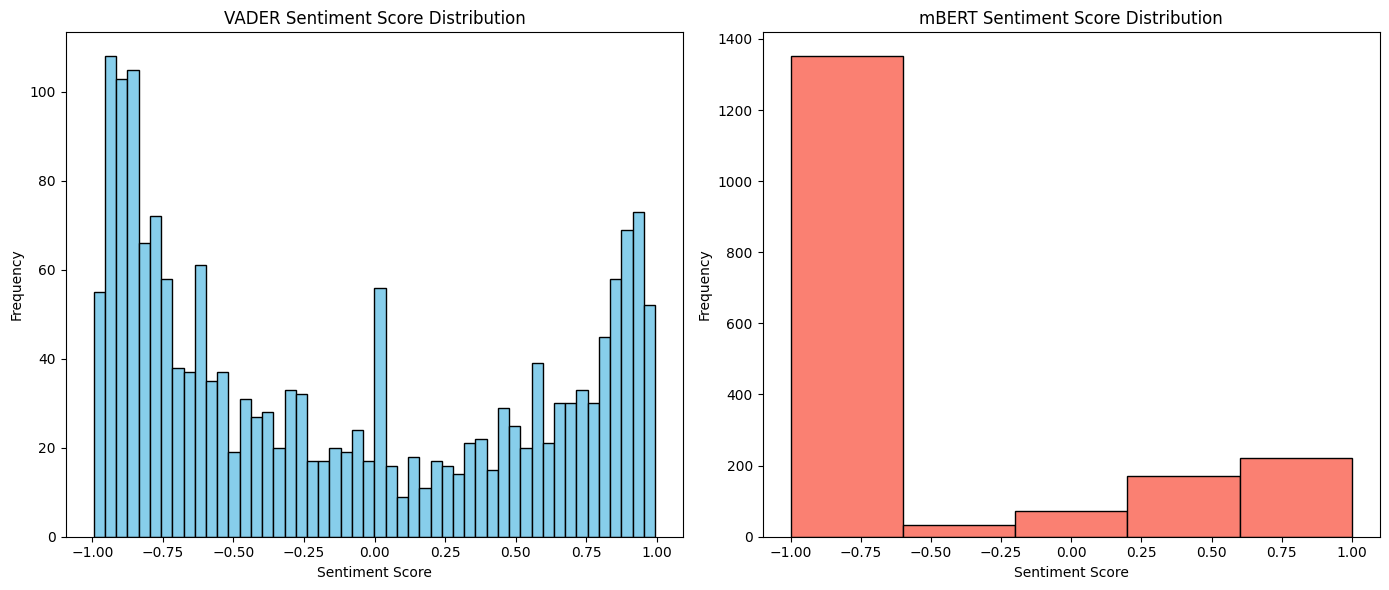

In [ ]:
import matplotlib.pyplot as plt

# Set up the figure
plt.figure(figsize=(14, 6))

# VADER Sentiment Score Histogram
plt.subplot(1, 2, 1)
plt.hist(df['sentiment_score'], bins=50, color='skyblue', edgecolor='black')
plt.title('VADER Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

# mBERT Sentiment Score Histogram
plt.subplot(1, 2, 2)
plt.hist(df['sentiment_score_mbert'], bins=5, color='salmon', edgecolor='black')  # Bins correspond to possible scores
plt.title('mBERT Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


/tmp/ipykernel_745756/2839653913.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['sentiment_score'], shade=True, color='blue')
/tmp/ipykernel_745756/2839653913.py:13: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df['sentiment_score_mbert'], shade=True, color='red')


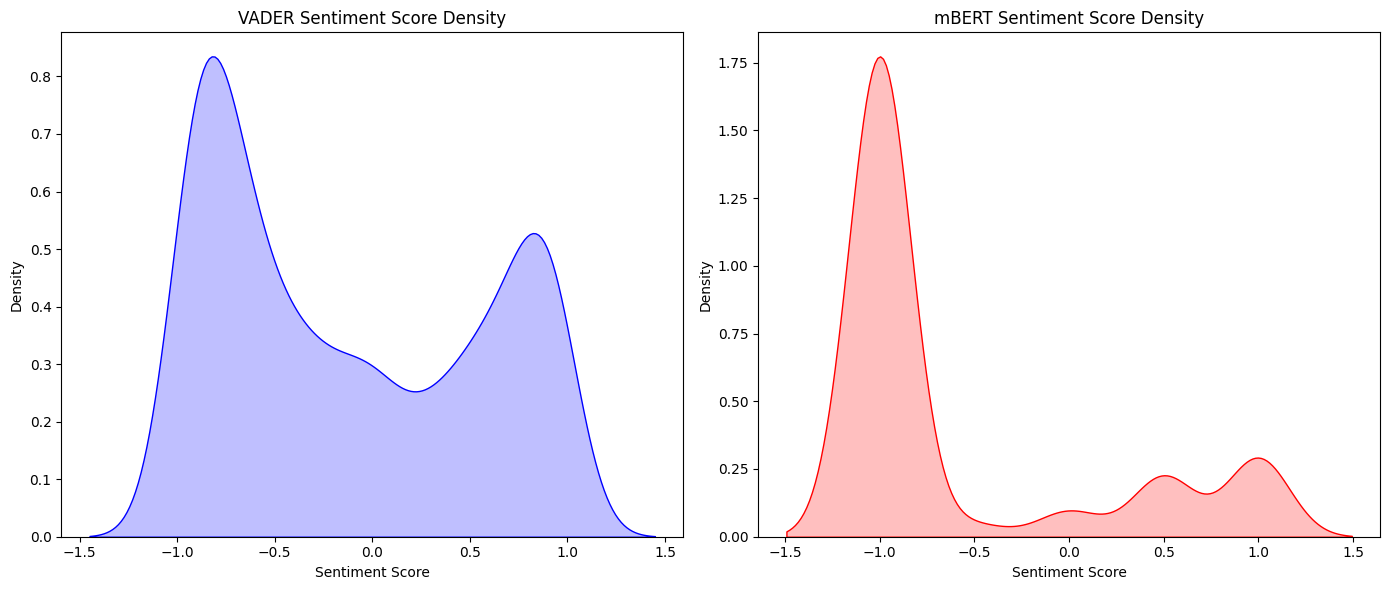

In [ ]:
import seaborn as sns

plt.figure(figsize=(14, 6))

# VADER Sentiment Score Density Plot
plt.subplot(1, 2, 1)
sns.kdeplot(df['sentiment_score'], shade=True, color='blue')
plt.title('VADER Sentiment Score Density')
plt.xlabel('Sentiment Score')

# mBERT Sentiment Score Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(df['sentiment_score_mbert'], shade=True, color='red')
plt.title('mBERT Sentiment Score Density')
plt.xlabel('Sentiment Score')

plt.tight_layout()
plt.show()


In [ ]:
correlation = df[['sentiment_score', 'sentiment_score_mbert']].corr(method='pearson')
print("Correlation between VADER and mBERT sentiment scores:")
print(correlation)


Correlation between VADER and mBERT sentiment scores:
                       sentiment_score  sentiment_score_mbert
sentiment_score               1.000000               0.673894
sentiment_score_mbert         0.673894               1.000000


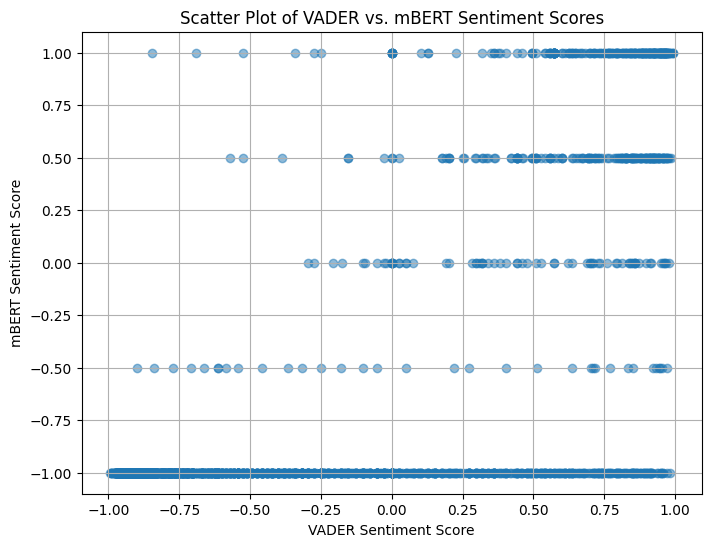

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(df['sentiment_score'], df['sentiment_score_mbert'], alpha=0.5)
plt.title('Scatter Plot of VADER vs. mBERT Sentiment Scores')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('mBERT Sentiment Score')
plt.grid(True)
plt.show()


In [ ]:
def classify_mbert_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_mbert'] = df['sentiment_score_mbert'].apply(classify_mbert_sentiment)


from sklearn.metrics import confusion_matrix, classification_report

# Create the confusion matrix
conf_matrix = confusion_matrix(df['sentiment'], df['sentiment_mbert'], labels=['Positive', 'Neutral', 'Negative'])

# Display the confusion matrix
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Positive', 'Neutral', 'Negative'], columns=['Positive', 'Neutral', 'Negative'])
print("Confusion Matrix:")
print(conf_matrix_df)

# Classification report
print("\nClassification Report:")
print(classification_report(df['sentiment'], df['sentiment_mbert'], labels=['Positive', 'Neutral', 'Negative']))


Confusion Matrix:
          Positive  Neutral  Negative
Positive       368       55       290
Neutral         12       10        52
Negative        11        7      1043

Classification Report:
              precision    recall  f1-score   support

    Positive       0.94      0.52      0.67       713
     Neutral       0.14      0.14      0.14        74
    Negative       0.75      0.98      0.85      1061

    accuracy                           0.77      1848
   macro avg       0.61      0.54      0.55      1848
weighted avg       0.80      0.77      0.75      1848



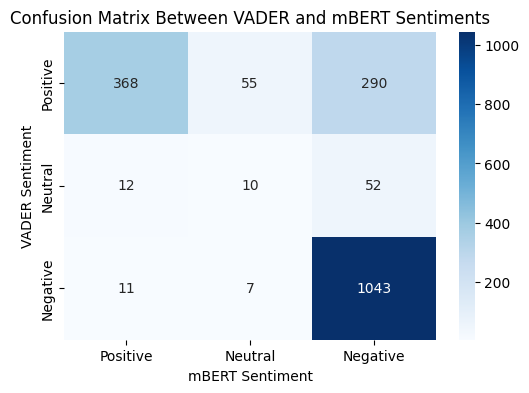

In [ ]:
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix Between VADER and mBERT Sentiments')
plt.ylabel('VADER Sentiment')
plt.xlabel('mBERT Sentiment')
plt.show()


## 3 Subjectivity Analysis

- 0= objetivo
- 1= subjetivo

In [ ]:
# Import TextBlob
from textblob import TextBlob

# Define a function to get subjectivity scores
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Apply the function to the dataset
df['subjectivity'] = df['review'].apply(get_subjectivity)

# Analyze the relationship between subjectivity and rating
import matplotlib.pyplot as plt

plt.scatter(df['subjectivity'], df['rating'])
plt.xlabel('Subjectivity')
plt.ylabel('Rating')
plt.title('Subjectivity vs. Rating')
plt.show()


In [ ]:
import seaborn as sns

# Plot the distribution of subjectivity scores
sns.histplot(df['subjectivity'], bins=20, kde=True)
plt.xlabel('Subjectivity Score')
plt.title('Distribution of Subjectivity Scores')
plt.show()


In [ ]:
# Boxplot of subjectivity scores by rating
sns.boxplot(x='rating', y='subjectivity', data=df)
plt.xlabel('Rating')
plt.ylabel('Subjectivity')
plt.title('Subjectivity Scores by Rating')
plt.show()


In [ ]:

language_subjectivity = df.groupby('source_language')['subjectivity'].mean().reset_index()
print(language_subjectivity)

# Visualize
sns.barplot(x='source_language', y='subjectivity', data=language_subjectivity)
plt.xlabel('Source Language')
plt.ylabel('Average Subjectivity')
plt.title('Average Subjectivity by Language')
plt.show()


## 4 Topic Modeling with LDA


In [ ]:
# Import necessary libraries
from gensim import corpora, models
import gensim
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
import spacy
from collections import Counter

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Load English tokenizer, POS tagger, etc.
nlp = spacy.load('en_core_web_sm')

# Initial stopwords list
stop_words = set(stopwords.words('english'))

# Domain-specific stopwords
domain_stopwords = ['flight', 'airline', 'flybondi', 'plane', 'air', 'flights', 'fly', 'airlines']
stop_words.update(domain_stopwords)

# Function to preprocess text
def preprocess(text):
    # Tokenize and lemmatize
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if token.lemma_.isalpha()]
    # Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Apply preprocessing
df['tokens'] = df['review'].apply(preprocess)

# Most common tokens (to see if any should be added to stopwords)
all_tokens = [token for tokens in df['tokens'] for token in tokens]
token_counts = Counter(all_tokens)
print(token_counts.most_common(50))


In [ ]:
good_threshold = 4
bad_threshold = 2
good_reviews = df[df['rating'] >= good_threshold].copy()
bad_reviews = df[df['rating'] <= bad_threshold].copy()


In [ ]:
def perform_lda(dataframe, num_topics=3):
    # Create dictionary and corpus
    dictionary = corpora.Dictionary(dataframe['tokens'])
    corpus = [dictionary.doc2bow(text) for text in dataframe['tokens']]

    lda_model = gensim.models.LdaMulticore(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=10,
        workers=2,
        random_state=42
    )

    # Print the topics
    for idx, topic in lda_model.print_topics(-1):
        print(f"Topic {idx+1}: {topic}\n")

    return lda_model, corpus, dictionary


In [ ]:
print("Topics in Bad Reviews:")
bad_lda_model, bad_corpus, bad_dictionary = perform_lda(bad_reviews)


Interpretación de 5 topics:
- Topic 1; Schedule changes and delays affectinc travel plans
- Topic 2: Poor customer service and unexpected charges
- Topic 3: Flight cancellation and time wasted
- Topic 4: Delays and financial loss
- Topic 5: Payment issues and no reimbursments

Interpretación de 3 topics:
- Topic 1 : Schedule Changes and Delays
- Topic 2 : Poor Service, Cancellations, and Extra Charges
- Topic 3 : Flight Cancellations and Time Lost 

In [ ]:
print("Topics in Good Reviews:")
good_lda_model, good_corpus, good_dictionary = perform_lda(good_reviews)


In [ ]:
from wordcloud import WordCloud

def plot_word_cloud(lda_model, dictionary, topic_num):
    words = dict(lda_model.show_topic(topic_num, 30))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_num+1}")
    plt.show()

# Plot word clouds for topics in bad reviews
for topic_num in range(bad_lda_model.num_topics):
    plot_word_cloud(bad_lda_model, bad_dictionary, topic_num)


## 5 Aspect-Based Sentiment analysis

- provee información sobre areas específicas de mejora
- ayuda a priorizar acciones basadas en aspectos que se consideraron negativos

In [ ]:
import numpy as np
aspects = ['service', 'price', 'comfort', 'staff', 'food', 'flight', 'delay']

def aspect_sentiment(review):
    sentences = nltk.sent_tokenize(review)
    aspect_sentiments = {}
    for aspect in aspects:
        aspect_sentiments[aspect] = []
        for sentence in sentences:
            if aspect in sentence.lower():
                score = sid.polarity_scores(sentence)['compound']
                aspect_sentiments[aspect].append(score)
    # Average sentiment per aspect
    for aspect in aspect_sentiments:
        if aspect_sentiments[aspect]:
            aspect_sentiments[aspect] = np.mean(aspect_sentiments[aspect])
        else:
            aspect_sentiments[aspect] = None
    return aspect_sentiments

df['aspect_sentiments'] = df['review'].apply(aspect_sentiment)

aspect_df = df['aspect_sentiments'].apply(pd.Series)

aspect_summary = aspect_df.mean()
print(aspect_summary)


plt.figure(figsize=(8, 5))
plt.barh(aspect_summary.index, aspect_summary.values, color='skyblue')
plt.xlabel('Sentiment Score')
plt.title('Average Sentiment Score by Aspect')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.show()


## 6 Flight Experience Stages
- Se puede sacar el relevance_score si se quiere uno promediado de manera uniforme
- ayuda a encontrar areas de mejora particulares a un proceso de vuelo

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re


# Palabras asociadas a flight stages
flight_stages_keywords = {
    'booking': ['booking', 'reservation', 'ticket purchase', 'purchase', 'buying tickets', 'online booking'],
    'check-in': ['check-in', 'checkin', 'check in', 'baggage drop', 'luggage drop', 'counter', 'kiosk', 'online check-in'],
    'boarding': ['boarding', 'gate', 'queue', 'line', 'boarding process', 'security', 'passport control'],
    'in-flight': ['in-flight', 'flight', 'onboard', 'cabin', 'crew', 'seat', 'seating', 'entertainment', 'food', 'beverage', 'service', 'comfort', 'turbulence'],
    'post-flight': ['post-flight', 'arrival', 'baggage claim', 'lost luggage', 'customer service', 'complaint', 'feedback', 'delay', 'connections', 'transit']
}

# Como el valor de relevance es muy chico entonces lo scaleamos un poco
df['scaled_relevance'] = df['relevance_score'] * 10

def get_stage_sentiments_weighted(row):
    review = row['review']
    sentiment_score = row['sentiment_score']
    scaled_relevance = row['scaled_relevance']
    stage_sentiments = {stage: [] for stage in flight_stages_keywords.keys()}
    review_lower = review.lower()
    # por cada review se busca si hay alguna palabra clave en cada etapa
    for stage, keywords in flight_stages_keywords.items():
        for keyword in keywords:
            if re.search(r'\b' + re.escape(keyword) + r'\b', review_lower):
                # si se encuentra la palabra clave se ajusta el score
                adjusted_score = sentiment_score * scaled_relevance # si no queremos que se ajuste en base a relavance sacamos el scaled_relevance
                stage_sentiments[stage].append(adjusted_score)

    # se hace una pasada por cada etapa para calcular el promedio de los scores ( sum(score * relevance) / sum(relevance) )
    for stage in stage_sentiments:
        if stage_sentiments[stage]:
            stage_sentiments[stage] = np.mean(stage_sentiments[stage])
        else:
            stage_sentiments[stage] = np.nan
    return pd.Series(stage_sentiments)

df_stage_sentiments = df.apply(get_stage_sentiments_weighted, axis=1)

# --- Graph 1: Combined Heatmap ---

# Calculate average sentiment score for each stage
stage_avg_sentiments = df_stage_sentiments.mean()

# Plot combined heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(stage_avg_sentiments.values.reshape(1, -1), annot=True, fmt=".2f", cmap='magma', xticklabels=stage_avg_sentiments.index)
plt.title('Average Sentiment Score per Flight Stage (Weighted by Relevance Score)')
plt.yticks([])
plt.show()

# --- Graph 2: Heatmap by Rating ---

# Combine stage sentiments with ratings
df_stage_ratings = pd.concat([df[['rating']], df_stage_sentiments], axis=1)

# Group by rating and calculate mean sentiment scores for each stage
stage_rating_avg_sentiments = df_stage_ratings.groupby('rating').mean()

# Order the ratings from 1 to 5
stage_rating_avg_sentiments = stage_rating_avg_sentiments.sort_index(ascending=True)

# Plot heatmap separated by rating score
plt.figure(figsize=(10, 6))
sns.heatmap(stage_rating_avg_sentiments, annot=True, fmt=".2f", cmap='magma', xticklabels=stage_rating_avg_sentiments.columns, yticklabels=stage_rating_avg_sentiments.index)
plt.title('Average Sentiment Score per Flight Stage by Rating (Weighted by Relevance Score)')
plt.xlabel('Flight Stage')
plt.ylabel('Rating')
plt.yticks(rotation=0)
plt.show()

# --- Graph 3: Bar Plot of Average Adjusted Sentiment Score per Rating ---

# Calculate adjusted sentiment score for each review
df['adjusted_sentiment'] = df['sentiment_score'] * df['scaled_relevance']

# Group by rating and calculate mean adjusted sentiment
rating_avg_sentiment = df.groupby('rating')['adjusted_sentiment'].mean().reset_index()

# Order the ratings from 1 to 5
rating_avg_sentiment = rating_avg_sentiment.sort_values('rating')

# Plot bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x='rating', y='adjusted_sentiment', data=rating_avg_sentiment, order=rating_avg_sentiment['rating'])
plt.title('Average Adjusted Sentiment Score per Rating')
plt.xlabel('Rating')
plt.ylabel('Average Adjusted Sentiment Score')
plt.xticks(rotation=0)
plt.show()

# --- Graph 4: Line Plot of Sentiment Trend Across Flight Stages ---

# Plot line chart
plt.figure(figsize=(10, 6))
stage_avg_sentiments.plot(kind='line', marker='o')
plt.title('Sentiment Trend Across Flight Stages (Weighted by Relevance Score)')
plt.xlabel('Flight Stage')
plt.ylabel('Average Adjusted Sentiment Score')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## 7 NPS


In [21]:
# Define NPS categories based on sentiment score
def predict_nps(score):
    if score >= 0.05:
        return 'Promoter'
    elif score <= -0.05:
        return 'Detractor'
    else:
        return 'Passive'

# Apply the function to your dataframe
df['nps_category'] = df['sentiment_score'].apply(predict_nps)

# Check the distribution of NPS categories
print(df['nps_category'].value_counts())


nps_category
Detractor    1061
Promoter      713
Passive        74
Name: count, dtype: int64


## 8 Review summary

In [22]:
from transformers import pipeline

# Inicializar el pipeline de resumen
summarizer = pipeline('summarization', model='facebook/bart-large-cnn')

# Debido a las limitaciones de entrada del modelo, resumir en fragmentos
max_chunk = 500
current_chunk = ''
summaries = []
total_reviews = len(df['review'])


All PyTorch model weights were used when initializing TFBartForConditionalGeneration.

All the weights of TFBartForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBartForConditionalGeneration for predictions without further training.


In [ ]:
df.head()


In [19]:
df.to_csv('../../data/en_analyzed.csv', index=False)


In [23]:
for i, review in enumerate(df['review'], start=1):
    print(f"Processing review {i}/{total_reviews}...")  # Progress print

    if len(current_chunk) + len(review) <= max_chunk:
        current_chunk += review + ' '
    else:
        input_length = len(current_chunk.split())
        dynamic_max_length = min(130, max(30, input_length // 2))

        # Generate summary for the current chunk
        summary = summarizer(current_chunk, max_length=dynamic_max_length, min_length=30, do_sample=False)
        summaries.append(summary[0]['summary_text'])

        # Reset the current chunk to start with the current review
        current_chunk = review + ' '

    # Optional: Show progress at intervals or after certain reviews are processed
    if i % 10 == 0:
        print(f"Processed {i} reviews, {total_reviews - i} remaining...")

# Summarize any remaining text
if current_chunk:
    input_length = len(current_chunk.split())
    dynamic_max_length = min(130, max(30, input_length // 2))

    summary = summarizer(current_chunk, max_length=dynamic_max_length, min_length=30, do_sample=False)
    summaries.append(summary[0]['summary_text'])

# Combine the summaries
final_summary = ' '.join(summaries)
print("Summarization complete!")
print(final_summary)


Processing review 1/1848...
Processing review 2/1848...
Processing review 3/1848...
Processing review 4/1848...


KeyboardInterrupt: 